# Ultra-High-Density Recording Baseline Subtractor

- Reads in an h5 file from Lead Labs Willow System (or anything that saves data as h5 files)
- Interprets the probe map and assigns impedance data to individual sites on the probe
- Displays selected channels (every 4th channel) at a time for exploring the traces individually
- Filters the data between 400 and 9500 Hz (in vivo recordings)

## User Input

In [1]:
# Assumes this python notebook, the data file, and the imp. file are in same dir
datafile = '20200324-third.h5'
impfile = 'impedance_20200403-105919.h5' # Impedance File
basefile = 'experiment_C20200403-105044.h5' # Saline baseline file
fs = 30000

## Import Dependencies

In [2]:
import h5py
import numpy as np
import os
import matplotlib.pyplot as plt
from IPython.display import HTML
from scipy.signal import butter, sosfiltfilt, sosfreqz
import time

## Read in impedence data

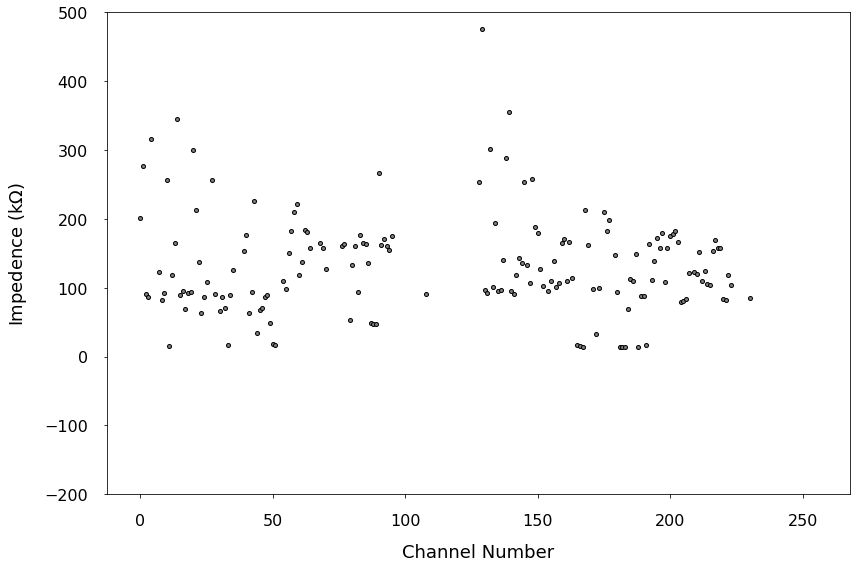

In [3]:
f_imp = h5py.File(impfile, 'r')

def get_impedence(f_imp):
    fig, ax = plt.subplots(figsize = (12,8))
    imp = f_imp['impedanceMeasurements'][:]
    x = np.where (imp > 0)[0]
    y = [imp[i] / 1000 for i in x] # kOhms
    ax.plot(x, y, ls = 'none', markersize = 4, marker = 'o', color = 'gray', mec = 'black')  
    ax.set_ylabel ('Impedence (k' + r'$\Omega$' + ')', fontsize = 18, labelpad = 15)
    ax.set_xlabel ('Channel Number', fontsize = 18, labelpad = 15)
    plt.tick_params(axis = 'both', which = 'major', pad = 15, labelsize = 16)
    init_avg = np.mean(y)
    init_sd = np.std(y)
    high = np.where(y > np.mean(y) + 2 * np.std(y))[0]
    low = np.where (y < np.mean(y)- 2 * np.std(y))[0]
    adj_y = [y1 for y1 in y if y1 not in low]
    adj_y = [y1 for y1 in y if y1 not in high]
    adj_high = np.where(y > np.mean(adj_y) + 2 * np.std(adj_y))[0]
    adj_low = np.where (y < np.mean(adj_y)- 2 * np.std(adj_y))[0]
    ax.set_ylim(-200,500)
    report = {'avg': np.mean(adj_y),
          'std': np.std(adj_y),
          'high': adj_high,
          'low' : adj_low}    
    
    display(HTML("<br><hr><h4>Mean impedence = <font color = 'red'>" + str(round(report['avg'],3)) + 
                 "</font><br><br> Standard Deviation =  <font color = 'red'>" + str(round(report['std'],3)) 
                 + '</font><br><br>' 
                 + "Channels with High Resistance (greater than 2 std above the mean) =  <font color = 'red'><br><br>"  
                 + str(report['high']).replace('[','').replace(']', '') + "</font><br><br>" +
                 "Channels with Low Resistance (less than 2 std below the mean) = <font color = 'red'><br><br>" +
                str(report['low']).replace('[','').replace(']', '') + "</font>" + " <br><hr color = 'gray'><br>"))
    
    ax.axhline(report['avg'], color = 'dimgray')
    ax.axhline(report['avg'] + report['std'], ls = ":", color = 'dimgray')
    ax.axhline(report['avg'] - report['std'], ls = ":", color = 'dimgray')

    plt.tight_layout()
    
    return report, x, y
    
imp_report, channels, imp = get_impedence (f_imp)

## Read in the Multichannel Data

In [4]:
f_data = h5py.File(datafile, 'r')
f_base = h5py.File(basefile, 'r')

# Pull data from h5 into variables
si = f_data.get('sample_index') # channel # (x)
ys = f_data.get('channel_data') # actual data in microvolts (y)
ys = ys[:, channels] # Remove unconnected channels (based on impedence data)

subs = f_base.get('channel_data') # Get baseline y for all channels
subs = subs[:, channels] # Remove unconnected channels


display (HTML("<br><hr><h4>Data consists of <font color = 'red'>" + str(ys.shape[1]) + 
              "</font> columns of data (channels, x) and <font color = 'red'>" + str(ys.shape[0]) + "</font> rows of data (measurements, y).<hr><br>"))

## Subtract Unfiltered baseline data from signals

In [ ]:
import pandas as pd

df = pd.DataFrame()
for channel in channels:
    clean_y = []
    last = 1
    for second in range (last, int(si[-1]/fs)): 
        for x in range (last-1, second * fs):
            temp = float(ys[x, channel]) - float(subs[x,channel]) # cast as float to avoid ushort_scalar error
            clean_y.append(temp)
        last = last + fs
    df[channel] = clean_y
    
df['x'] = [i for i in range(0, int(len(df[0])))]
print(df.shape)

## Save Subtracted Data

In [ ]:
hf_sub = h5py.File(datafile.replace('.h5', '_subtracted.h5'), 'w')
hf_sub.create_dataset('x', data = df['x'])
hf_sub.create_dataset('subtracted', data=df.loc[:, df.columns != 'x'])
hf_sub.close()